# Machine Learning Model Developing for Mobile Tariff Recommendation

**The goal of the project is to select a machine learning model to recommend a tariff plan to users. Prediction accuracy (accuracy) - 0.75 and higher.**  

- First, let's load and examine the available data.  
- Then we divide the data into three samples - training, validation and test data.  
- After that, we will train the models on the training set and evaluate the accuracy of the model on the validation set.  
- Based on the test results, if the minimum prediction accuracy is achieved, we will select the model with the highest accuracy value.  
- Next, we will check the model on the test sample and check the model for adequacy.

In [1]:
# Importing libraries and modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

sns.set(rc={'figure.figsize':(14, 8)}, palette='Set2', font_scale=1.25)

In [2]:
# random state set
RS = 12345

## Reading and exploring the data

### Data description  

Every observation in the dataset contains monthly behavior information about one user. The information given is as follows:  

сalls — number of calls  
minutes — total call duration in minutes  
messages — number of text messages  
mb_used — Internet traffic used in MB  
is_ultra — plan for the current month (Ultra - 1, Smart - 0)  

Reading the dataset file into the data variable and make sure that the data read is correct. Let's look at general information about the dataset.

In [3]:
data = pd.read_csv('datasets/users_behavior.csv')

In [4]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


**Summary**

The dataset has 3214 rows of data in 5 columns. The amount of data is sufficient. There are no gaps in the data, all data types are specified correctly. We can start working with this data.

## Data Analysis and Data Preparation

Plotting histograms and boxplots

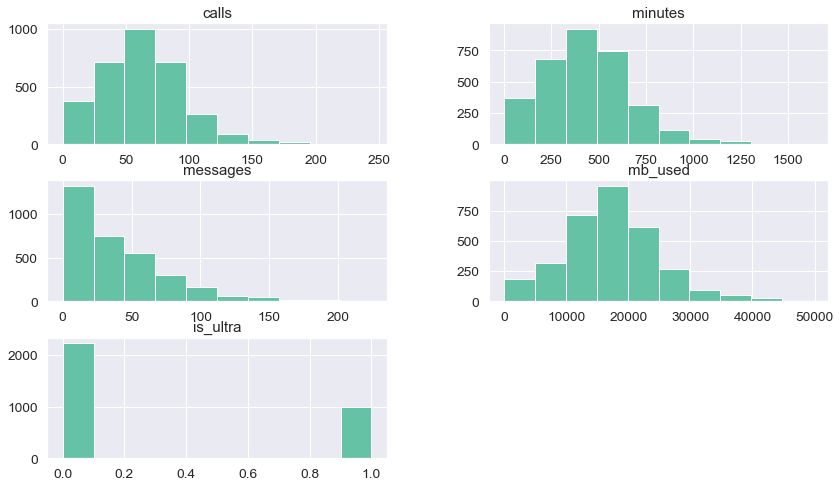

In [6]:
data.hist();

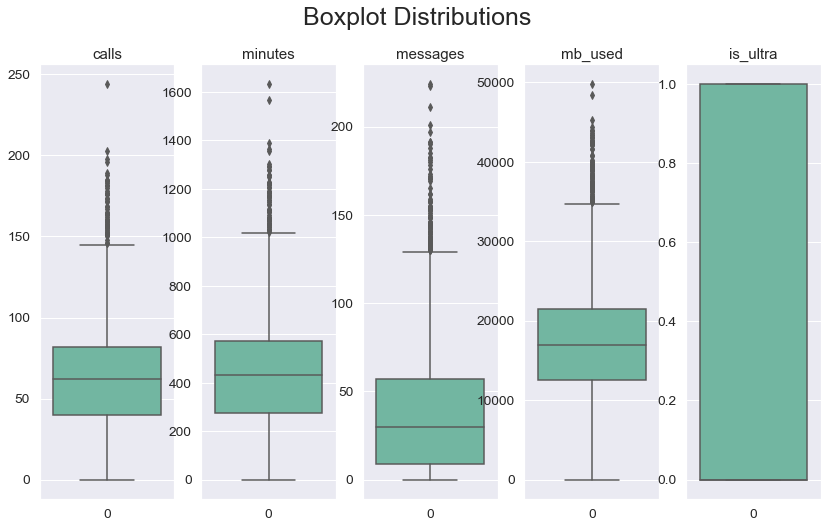

In [7]:
fig, axes = plt.subplots(1, 5)
fig.suptitle('Boxplot Distributions', fontsize=25)

for i, feature in enumerate(data.columns):
    sns.boxplot(data=data[feature], ax=axes[i])
    axes[i].set_title(feature, fontsize=15)
    
plt.plot();

In [8]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


There are noticeable outliers in the data. The distribution forms of calls and minutes are very similar.

Let us also plot a correlation matrix.

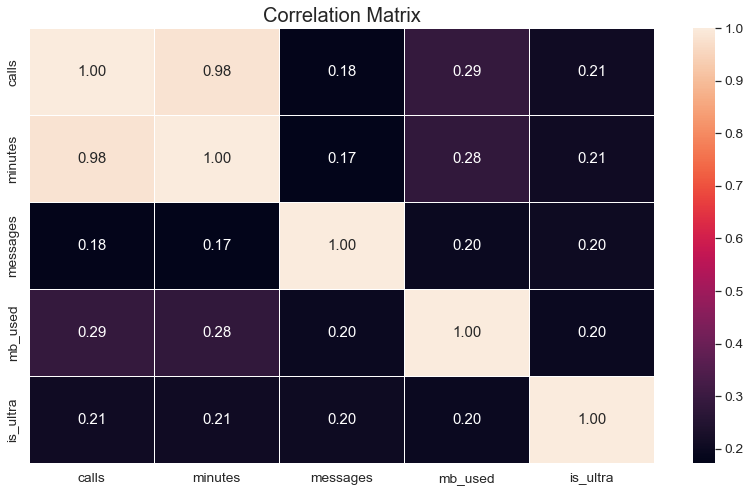

In [9]:
sns.heatmap(data.corr(), annot=True, linewidth=.5, fmt=".2f")
plt.title('Correlation Matrix', fontsize=20);

We can build a pairplot to look at the difference between classes distributions.

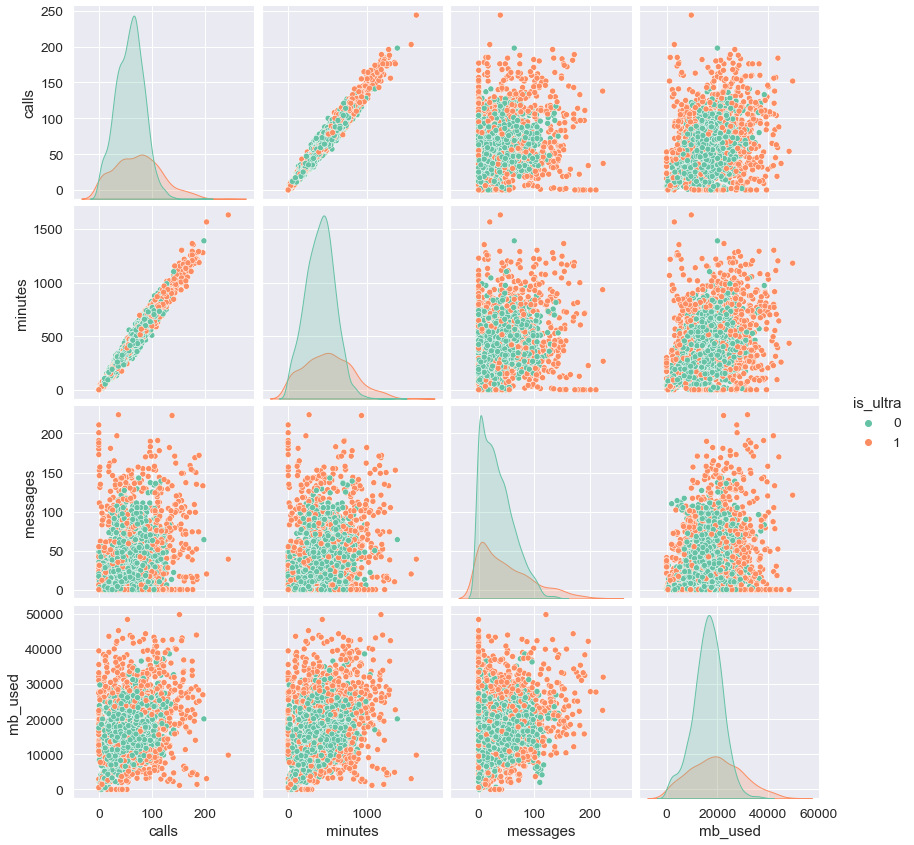

In [10]:
sns.pairplot(data, hue='is_ultra', height=3);

There is a very strong linear correlation between the data in the 'calls' and 'minutes' columns. When using linear models, this can interfere with learning. To reduce the influence of feature multicollinearity, regularization should be used when training linear models.  

On the pairplot it can be noticed a fairly visible difference between classes according to various features.

## Splitting of data into samples and features normalization

The target feature we are interested in is in the 'is_ultra' column. Our prediction problem is reduced to a binary classification problem, that is, to predict the target feature 'is_ultra' for a user with given features. First, we separate data with a target feature into a separate dataset and a separate dataset with other features.

In [11]:
data_features = data.drop(['is_ultra'], axis=1)

In [12]:
data_target = data['is_ultra']

### Feature Normalization

In [13]:
scaler = StandardScaler()
scaler = scaler.fit(data_features)
data_features = scaler.transform(data_features)

### Splitting the data into three sets

Now let's divide the data with features and the target into three sets: training, validation, and test in the proportions of 3:1:1, respectively.

Since the standard sklearn train_test_split method splits only into two sets, we'll perform the split sequentially: we start by splitting the samples into 60% and 40%, and then we split the 40% part into two equal parts. To evenly split the data, specify the data by the target attribute in the "stratify" parameter.

In [14]:
features_train, features_valid, target_train, target_valid = train_test_split(
    data_features, 
    data_target, 
    test_size=0.4, 
    random_state=RS, 
    stratify=data_target)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, 
    target_valid, 
    test_size=0.5, 
    random_state=RS, 
    stratify=target_valid)

Checking for correct splitting by size of sets:

In [15]:
len(target_train), len(target_valid), len(target_test)

(1928, 643, 643)

In [16]:
len(features_train), len(features_valid), len(features_test)

(1928, 643, 643)

The partitioning of the data into sets was carried out correctly, now we can proceed to explore machine learning models.

## ML Model Research

We will study the models in the following way. At frist we train the model on the training set and check the metric on the validation set. We explore five different models. We will sequentially sort through the hyperparameters and look for the best ones.

In [17]:
def accuracy_plot(estimator, 
                  parameter, 
                  param_dist, 
                  features_train, 
                  target_train, 
                  features_valid, 
                  target_valid):
    """
    A function for plotting the dependence of accuracy on the value of the hyperparameter
    """
    results_table = pd.DataFrame()
    for i, value in enumerate(param_dist):
        model = estimator.set_params(**{parameter: value})
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        results_table.loc[i, 'param_value'] = value
        results_table.loc[i, 'accuracy'] = accuracy_score(target_valid, predictions)
        
    sns.lineplot(data=results_table, x='param_value', y='accuracy')

In [18]:
def model_test(model, 
               features_train, 
               target_train, 
               features_test, 
               target_test):
    """
    Function for testing models
    """
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)
    return accuracy_score(target_test, predictions)

### Logistic Regression Model

For the logistic regression model, we will iterate over the hyperparameter 'C' - Inverse of regularization strength. And also compare two different solvers - algorithms to use in the optimization problem.

In [19]:
# Distribution of th hyperparameter for iterate over
C_dist = np.arange(0.0001, 0.2, 0.001)

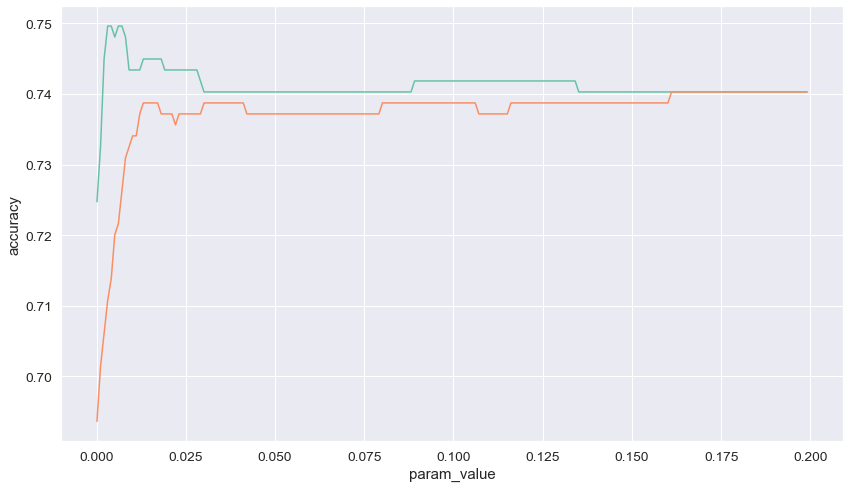

In [20]:
plt.figure()

accuracy_plot(LogisticRegression(solver='liblinear', penalty='l2'), 
              'C', 
              C_dist, 
              features_train, 
              target_train, 
              features_valid, 
              target_valid)

accuracy_plot(LogisticRegression(solver='saga', penalty='l2'), 
              'C', 
              C_dist, 
              features_train, 
              target_train, 
              features_valid, 
              target_valid)

plt.show()

'liblinear' solver works more efficiently in our case. In order to consider the optimal range of the hyperparameter, let's plot it on a larger scale.

In [21]:
C_dist = np.arange(0.0001, 0.02, 0.001)

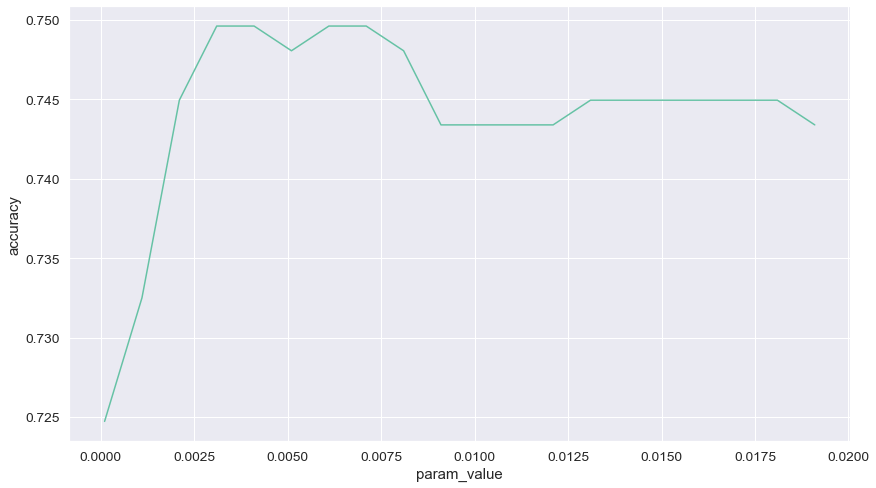

In [22]:
accuracy_plot(LogisticRegression(solver='liblinear', penalty='l2'), 
              'C', 
              C_dist, 
              features_train, 
              target_train, 
              features_valid, 
              target_valid)

The optimal C value is about 0.0035

In [23]:
lr_results = model_test(LogisticRegression(solver='liblinear', 
                                           penalty='l2', 
                                           C=0.0035), 
                        features_train, 
                        target_train, 
                        features_valid, 
                        target_valid)

The optimal value of Accuracy on the validation set:

In [24]:
lr_results

0.7480559875583204

### DecisionTree Model

For Decision Tree model, we will iterate over the maximum depth, min samples split and min samples leaf parameters.

In [25]:
max_depth_dist = range(1, 16)

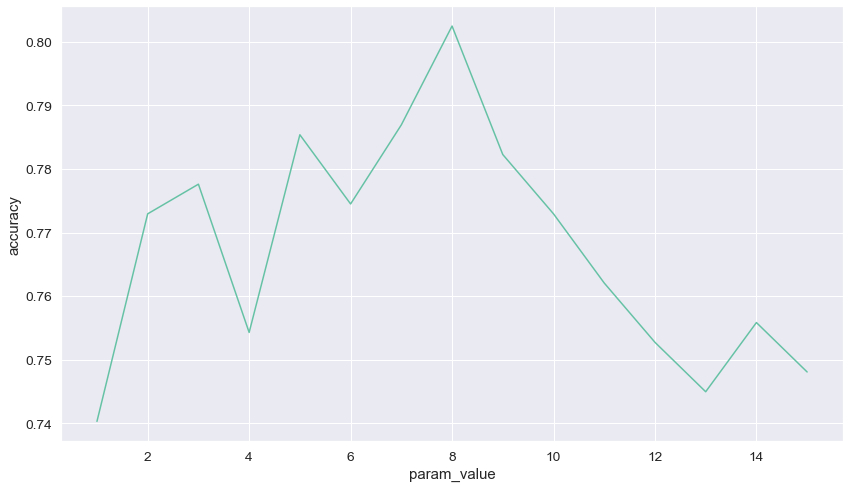

In [26]:
accuracy_plot(DecisionTreeClassifier(random_state=RS), 
              'max_depth', 
              max_depth_dist, 
              features_train, 
              target_train, 
              features_valid, 
              target_valid)

The optimal max_depth in our case is 8.

In [27]:
min_samples_split_dist = range(2, 101, 1)

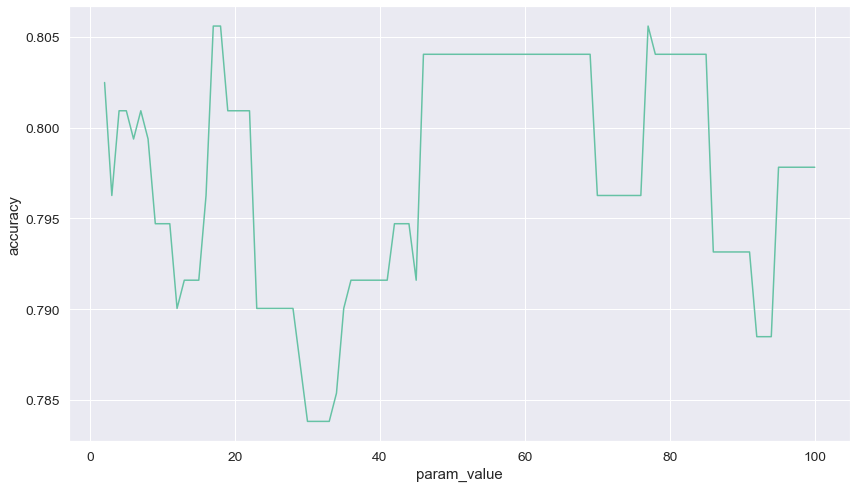

In [28]:
accuracy_plot(DecisionTreeClassifier(max_depth=8, random_state=RS), 
              'min_samples_split', 
              min_samples_split_dist, 
              features_train, 
              target_train, 
              features_valid, 
              target_valid)

Despite the fact that Accuracy is higher around the value of 18, it is still better to take the optimal value of the hyperparameter from the area where the accuracy is more stable - there is a clear plateau on the graph between 45 and 70. In this range, the model works more stably, and the metric is just a slightly lower. Let's take 50 as the optimal value for min_samples_split.

In [29]:
min_samples_leaf_dist = range(1, 25, 1)

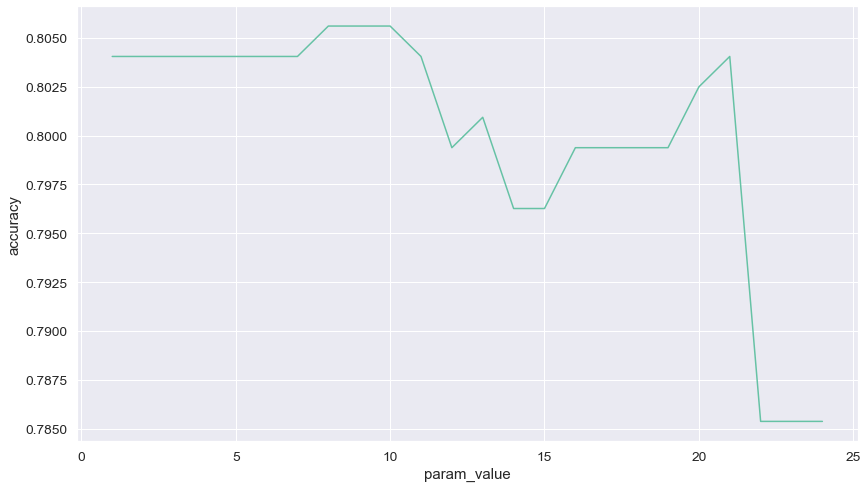

In [30]:
accuracy_plot(DecisionTreeClassifier(max_depth=8,
                                     min_samples_split=50,
                                     random_state=RS), 
              'min_samples_leaf', 
              min_samples_leaf_dist, 
              features_train, 
              target_train, 
              features_valid, 
              target_valid)

The optimal min_samples_leaf value is about 8.

Now let's test our Decision Tree Model

In [31]:
dt_results = model_test(DecisionTreeClassifier(max_depth=8, 
                                               min_samples_split=50, 
                                               min_samples_leaf=7), 
                        features_train, 
                        target_train, 
                        features_valid, 
                        target_valid)

And Accuracy on Decision Tree model is:

In [32]:
dt_results

0.8040435458786936

Much better than Linear Model

### Random Forest Model

For the Random Forest model, we will iterate different values of the hyperparameters one after another for the number of trees and the maximum depth of the tree.

In [33]:
n_estimators_dist = range(1, 251, 5)

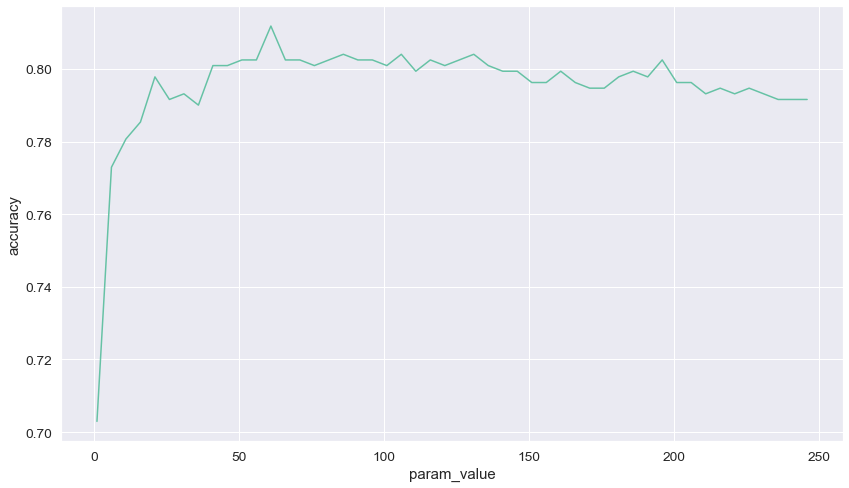

In [34]:
accuracy_plot(RandomForestClassifier(random_state=RS), 
              'n_estimators', 
              n_estimators_dist, 
              features_train, 
              target_train, 
              features_valid, 
              target_valid)

The optimal range we are interested in is about 60

In [35]:
max_depth_dist = range(1, 25, 1)

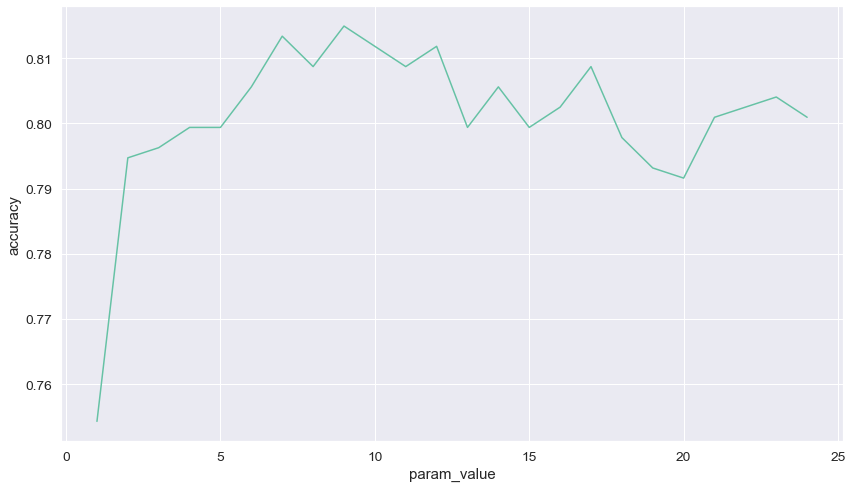

In [36]:
accuracy_plot(RandomForestClassifier(n_estimators=60, random_state=RS), 
              'max_depth', 
              max_depth_dist, 
              features_train,
              target_train, 
              features_valid, 
              target_valid)

The optimal value of the maximum depth in our case is 7.

In [37]:
rf_results = model_test(RandomForestClassifier(max_depth=7, 
                                               n_estimators=120,
                                               random_state=RS), 
                        features_train, 
                        target_train, 
                        features_valid, 
                        target_valid)

Model Accuracy on the validation set:

In [38]:
rf_results

0.8149300155520995

### Extra Trees Classifier Model

For this model, we will explore two different separation criterions (functions to measure the quality of a split), the number of trees and their maximum depth.

In [39]:
n_estimators_dist = range(1, 401, 5)

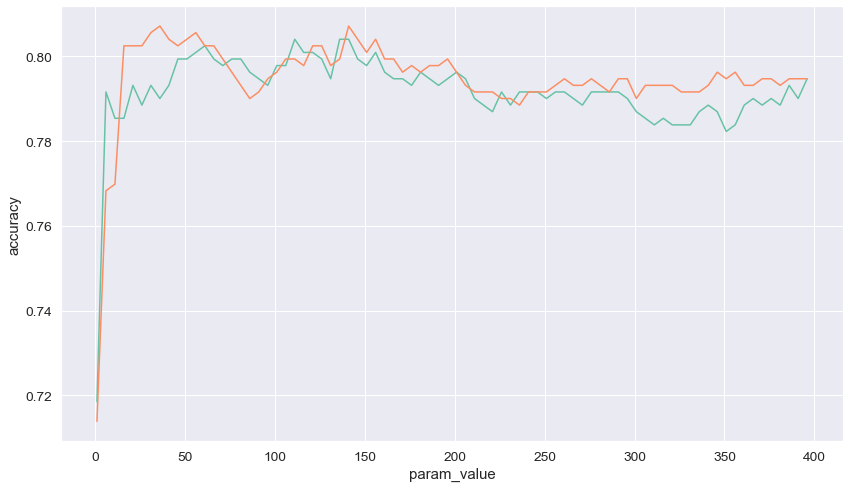

In [40]:
plt.figure()

accuracy_plot(ExtraTreesClassifier(random_state=RS, 
                                   criterion='gini'), 
              'n_estimators', 
              n_estimators_dist, 
              features_train, 
              target_train, 
              features_valid, 
              target_valid)

accuracy_plot(ExtraTreesClassifier(random_state=RS, 
                                   criterion='entropy'), 
              'n_estimators', 
              n_estimators_dist, 
              features_train, 
              target_train, 
              features_valid, 
              target_valid)

plt.show()

The most optimal solution seems the entropy criterion and 40 trees.

In [41]:
min_samples_leaf_dist = range(1, 31, 1)

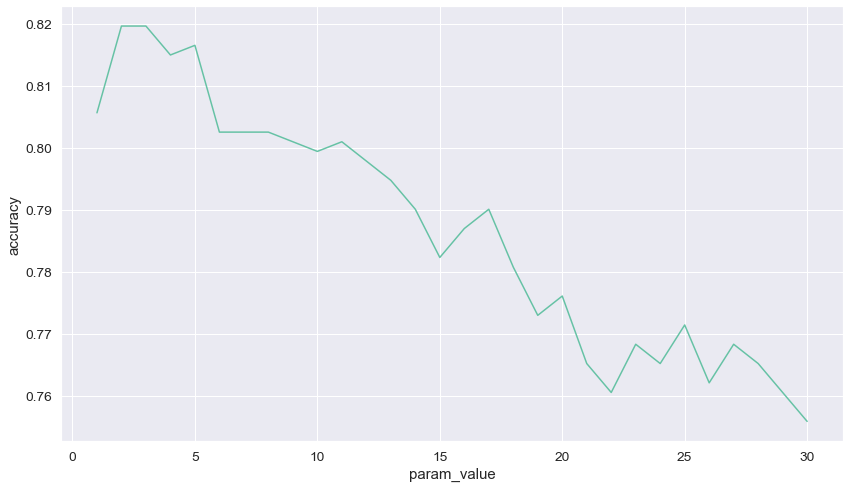

In [42]:
accuracy_plot(ExtraTreesClassifier(criterion='entropy',
                                   n_estimators=40, 
                                   random_state=RS), 
              'min_samples_leaf', 
              min_samples_leaf_dist,
              features_train,
              target_train,
              features_valid,
              target_valid)

Optimal value of min_samples_leaf is 3

In [43]:
max_depth_dist = range(1, 25, 1)

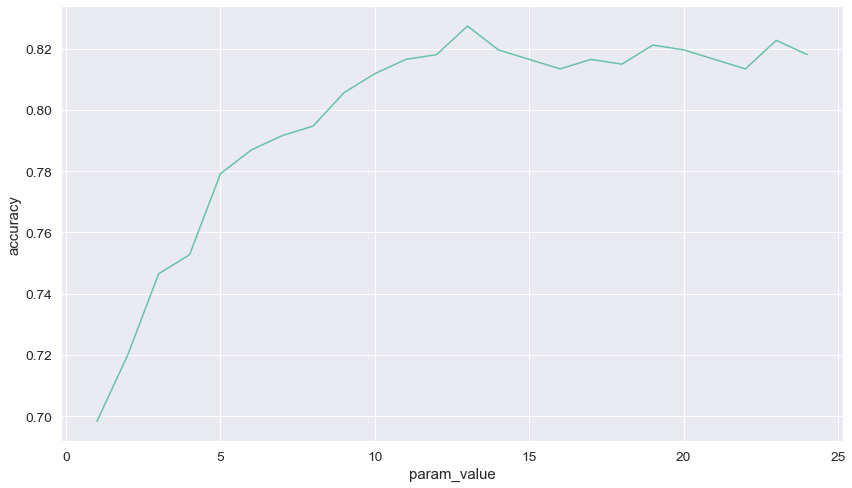

In [44]:
accuracy_plot(ExtraTreesClassifier(criterion='entropy', 
                                   n_estimators=40, 
                                   min_samples_leaf=3, 
                                   random_state=RS), 
              'max_depth', 
              max_depth_dist, 
              features_train, 
              target_train, 
              features_valid, 
              target_valid)

Optimal max_depth value is 13

In [45]:
et_results = model_test(ExtraTreesClassifier(criterion='entropy', 
                                             n_estimators=40, 
                                             min_samples_leaf=3, 
                                             max_depth=13, 
                                             random_state=RS), 
                        features_train, 
                        target_train, 
                        features_valid, 
                        target_valid)

Best Accuracy on validation set is:

In [46]:
et_results

0.8273716951788491

### Gradient Boosting Model

For the gradient boosting model, will look at various values of number of estimators, as well as the learning rate and different loss functions.

In [47]:
n_estimators_dist = range(1, 300, 10)

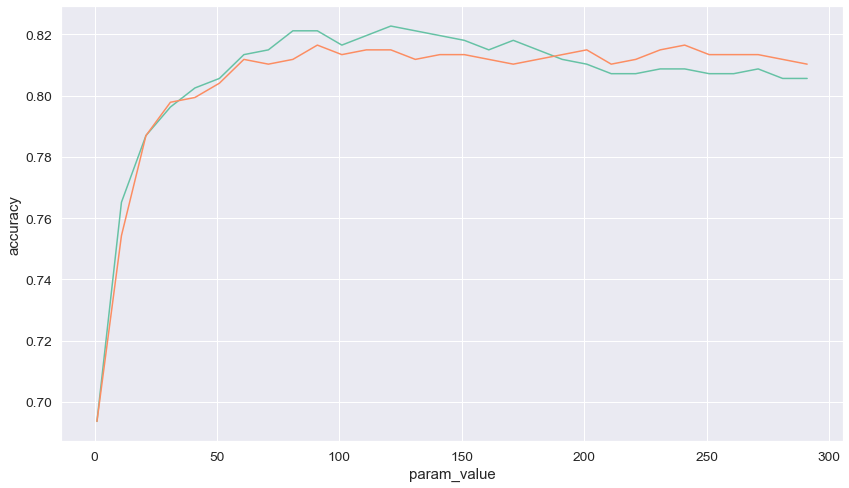

In [48]:
plt.figure()

accuracy_plot(GradientBoostingClassifier(random_state=RS, 
                                         loss='log_loss', 
                                         learning_rate=0.07),
              'n_estimators', 
              n_estimators_dist, 
              features_train, 
              target_train, 
              features_valid, 
              target_valid)

accuracy_plot(GradientBoostingClassifier(random_state=RS,
                                         loss='exponential',
                                         learning_rate=0.07),
              'n_estimators', 
              n_estimators_dist,
              features_train,
              target_train, 
              features_valid, 
              target_valid)

plt.show()

As can be clearly seen on the graph, the optimal loss function is log_loss with the number of estimators around 120. Let's fix these parameters and iterate over the learning rate.

In [49]:
learning_rate_dist = np.arange(0.001, 0.5, 0.005)

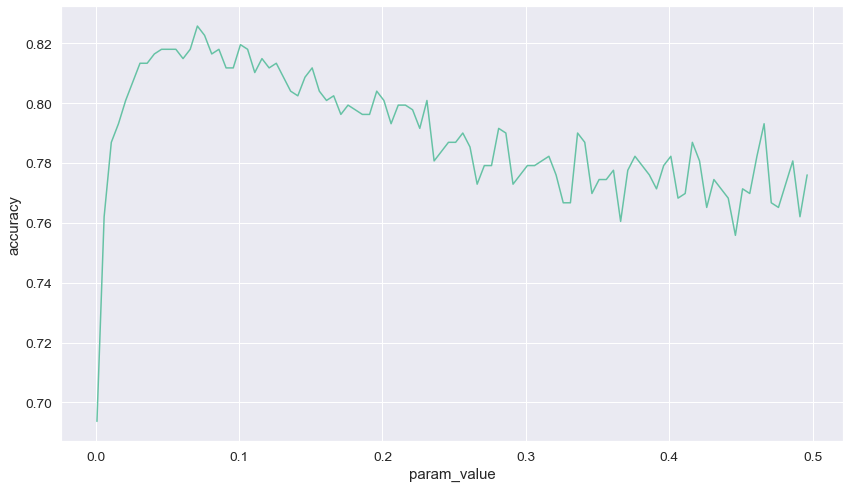

In [50]:
accuracy_plot(GradientBoostingClassifier(n_estimators=120,
                                         loss='log_loss',
                                         random_state=RS), 
              'learning_rate', 
              learning_rate_dist,
              features_train,
              target_train, 
              features_valid, 
              target_valid)

After rate 0.1, the quality droping down. Let's take a closer look at the range from 0.001 to 0.1.

In [51]:
learning_rate_dist = np.arange(0.001, 0.1, 0.005)

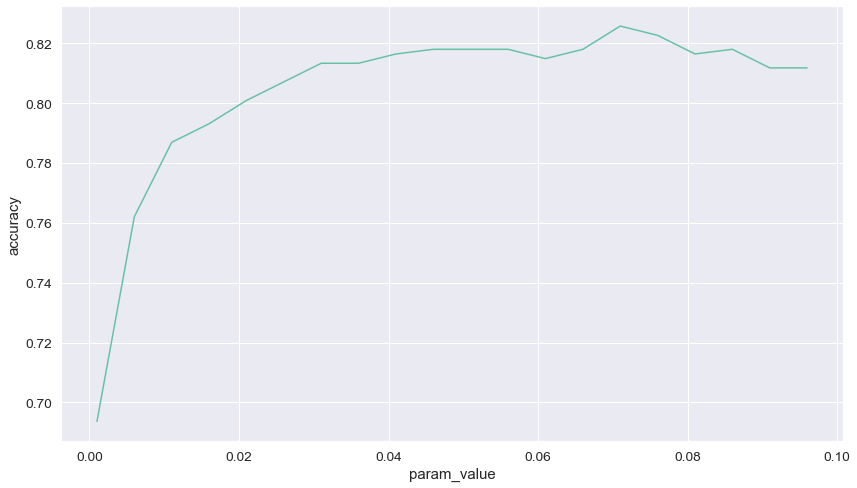

In [52]:
accuracy_plot(GradientBoostingClassifier(n_estimators=120,
                                         loss='log_loss',
                                         random_state=RS), 
              'learning_rate',
              learning_rate_dist,
              features_train, 
              target_train,
              features_valid, 
              target_valid)

Optimal learning rate is 0.07.

In [53]:
results_gb = model_test(GradientBoostingClassifier(loss='log_loss', 
                                                   learning_rate=0.07, 
                                                   n_estimators=120,
                                                   random_state=RS),
                        features_train,
                        target_train,
                        features_valid,
                        target_valid)

The optimal learning rate here is about 0.07.

In [54]:
results_gb

0.8211508553654744

Summarizing the results of all models in a single table

In [55]:
pd.DataFrame([lr_results, dt_results, rf_results, et_results, results_gb], 
             index=['Logistic Regression', 
                    'Decisioin Tree', 
                    'Random Forest', 
                    'Extra Trees', 
                    'Gradient Boosting'], 
             columns=['Accuracy'])

,Accuracy
Logistic Regression,0.748056
Decisioin Tree,0.804044
Random Forest,0.814930
Extra Trees,0.827372
Gradient Boosting,0.821151


**Summary**

On all five models, the accuracy results on the validation samples were greater than 0.75. The highest accuracy value was recorded on the ExtraTrees model: 0.827.

We make a choice in favor of an Extra Trees Classifier Model. Let's check the accuracy of this model on the test set.

## Accuracy Check on the test split

In [56]:
et_results = model_test(ExtraTreesClassifier(criterion='entropy', 
                                             n_estimators=40, 
                                             min_samples_leaf=3, 
                                             max_depth=13, 
                                             random_state=RS), 
                        features_train, 
                        target_train, 
                        features_test, 
                        target_test)

In [57]:
et_results

0.8289269051321928

**Conclusion**

On the test split the model showed almost the same accuracy. The model has been passed the test.

## Model adequacy check

In order to check the model for adequacy, it can be compared with a constant model. As a constant model, let's take a Dummy Classifier with the strategy='most_frequent' hyperparameter, which means that the model will choose the most frequent value of the target.

In [58]:
dummy_results = model_test(DummyClassifier(strategy='most_frequent', 
                                           random_state=RS),
                           features_train, 
                           target_train, 
                           features_test, 
                           target_test)

Accuracy for constant model on the test split:

In [59]:
dummy_results

0.6936236391912908

**Conclusion**

The model we have chosen is significantly superior in prediction accuracy to the constant model. Thus, we can conclude that the selected model based on the Random Forest algorithm has been tested for adequacy.

## Summary

Based on the available data of the mobile operator "Megaline" about users who switched to new tariffs, a model was built to recommend new tariffs for users who using archived tariffs.

The source dataset is 3214 rows long, 4 columns with features and 1 column with target values. Then the dataset was divided into two parts - with features and target values. Then they were divided into 6 samples, three for each split: training, validation and test in a ratio of 3:1:1.

Then the Data preparation was also carried out. In particular, stratification and normalization.

Five classification models were explored:
  *  Decision Tree Classifier
  *  Random Forest Classifier
  *  Logistic Regression
  *  Extra Trees Classifier
  *  Gradient Boosting Classifier

The models were trained on training set. The accuracy score was used as a criterion for the quality of training, which was calculated for each of the trained models on the validation set.

The selection of optimal values of hyperparameters was carried out for all five models.

* Logistic Regression    0.748
* Decisioin Tree	     0.804
* Random Forest	         0.815
* Extra Trees	         0.829
* Gradient Boosting	     0.821

According to the results of the study, we chose Extra Trees Classifier model. The accuracy score for this model is 0.829 on the validation set.

Then the model was tested on a test split. The accuracy score on the test split was almost the same - 0.83.

The adequacy of the model was checked by comparison with a constant model. The result of predictions of a constant model on the test set is 0.69. The results of the chosen model are ultimately significantly superior to the results of constant predictions. From which we can conclude that the chosen model is suitable for recommending the company's traffs.
